In [130]:
import numpy as np
import pandas as pd
import pingouin as pg
from scipy import stats
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from analysis_helper import analysis_tables, table_maker

In [21]:
#call_raw_tables
prior, data, numbers, words, participants_with_na_values = analysis_tables()

#call_task_tables
lambda_table = table_maker(3, 2, check_string='lambda')
isinstance_table = table_maker(0, 1, check_string='isinstance')
enumerate_table = table_maker(1, 0, check_string='enumerate')
sum_table = table_maker(2, 3, check_string='sum(')

In [15]:
#pre_analysis_tables
def no_preset_table(table_name):
    no_preset_table = table_name.loc[table_name.change.str.contains('No_preset', na=False),
                                     ['id_user', 'group', 'answer_block0', 'answer_block1', 'delta_time',
                                      'how_helpful', 'how_comfortable']]
    return no_preset_table


def no_set_table(table_name):
    no_set_table = table_name.loc[table_name.change.str.contains('No_set', na=False),
                                  ['id_user', 'group', 'answer_block0', 'answer_block1', 'delta_time',
                                   'how_helpful', 'how_comfortable']]
    return no_set_table


def solution_change_table(table_name, set_type):
    solution_change_table = table_name.loc[(table_name.change.isin([True, False])),
                                     ['id_user', 'group', 'answer_block0', 'answer_block1',
                                      "task_time_block0", "task_time_block1",
                                      'delta_time', 'change', 'how_helpful', 'how_comfortable']]
    solution_change_table['set_type'] = str(set_type)
    return solution_change_table

In [122]:
#to_see_the_tables

#lambda_table
#no_preset_table(lambda_table)
#solution_change_table(lambda_table, "lambda")
#no_set_table(lambda_table)

#isinstance_table
#no_preset_table(isinstance_table)
#no_set_table(isinstance_table)
#solution_change_table(isinstance_table, "isinstance")

#enumerate_table
#no_preset_table(enumerate_table)
#no_set_table(enumerate_table)
#solution_change_table(enumerate_table, "enumerate")

#sum_table
#no_preset_table(sum_table)
#no_set_table(sum_table)
#solution_change_table(sum_table, "sum")

In [35]:
#statistical_analysis_functions

#delta or change corr with questions about helpfulness and comfortability
def corr_result(table_name, x, y):
    table_name = table_name.loc[table_name.group > 0].copy(deep=True)
    table_name['how_helpful'] = table_name['how_helpful'].astype(int)
    table_name['how_comfortable'] = table_name['how_comfortable'].astype(int)
    pcor = pg.partial_corr(data=table_name, x=x, y=y, covar='group').round(3)
    return pcor


#stat sig of the group effect on change presence
def chi2_result(table_name, set_type):
    data = solution_change_table(table_name, set_type)
    data_crosstab = pd.crosstab(data.group, data.change)
    return chi2_contingency(data_crosstab)


#stat sig of the group effect on delta_time
def anova_result(table_name):
    table_name = table_name[(np.abs(stats.zscore(table_name["delta_time"])) < 3)]
    aov = pg.anova(dv='delta_time', between='group', data=table_name, detailed=True)
    return aov

In [141]:
#difference in months of Python experience
x=prior.loc[prior.exp==0, ['months']]
y=prior.loc[prior.exp==1, ['months']]
stats.ttest_ind(x, y, equal_var=False)

Ttest_indResult(statistic=array([3.00934147]), pvalue=array([0.00345603]))

In [ ]:
#correlation between helpfulness and comfortability levels
corrhow_table = isinstance_table.loc[isinstance_table.group > 0].copy(deep=True)
corrhow_table['how_helpful'] = corrhow_table['how_helpful'].astype(int)
corrhow_table['how_comfortable'] = corrhow_table['how_comfortable'].astype(int)
corrhow_table = corrhow_table.loc[:, ['id_user',"how_helpful", "how_comfortable"]]
pcor = pg.partial_corr(corrhow_table, "how_helpful", "how_comfortable").round(3)

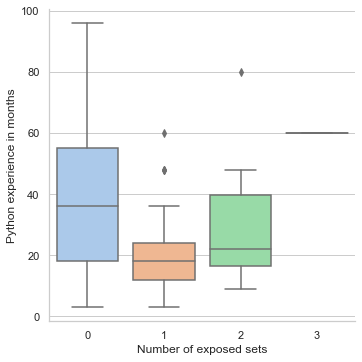

In [26]:
#plot_months_to_number_of_set_corr
sns.set_theme(style="whitegrid", palette="pastel")
ax = sns.catplot(x="set_count", y="months", kind="box", data=prior)
ax.set(ylabel="Python experience in months", xlabel="Number of exposed sets")

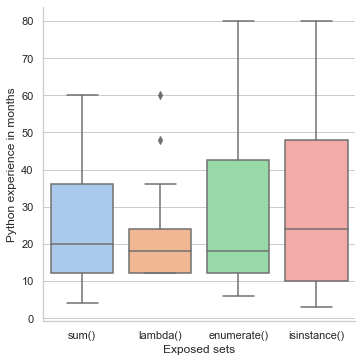

In [25]:
#plot_months_to_types_of_set_corr
participants_prior = prior.loc[(prior.exp == 1)]
participants = pd.DataFrame(participants_prior.set.str.split(',').tolist(), index=participants_prior.username).stack()
participants = participants.reset_index([0, 'username'])
participants.columns = ['username', 'set']
participants = pd.merge(participants_prior, participants, on=['username'], suffixes=('_prior', '_type') )
participants = participants.loc[:, ['username', 'months', 'set_count', 'set_type']]

sns.set_theme(style="whitegrid", palette="pastel")
ax = sns.catplot(x="set_type", y="months", data=participants, kind="box")
ax.set(ylabel="Python experience in months", xlabel="Exposed sets")

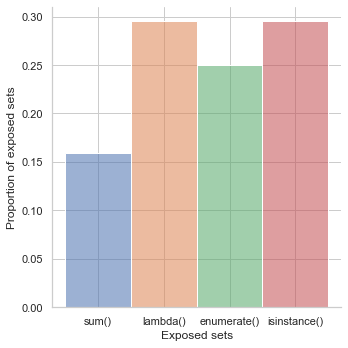

In [27]:
#plot_percentage_of_set_types
sns.set_theme(style="whitegrid")
ax = sns.displot(participants, x="set_type", hue="set_type", stat="density", alpha=0.55, legend=False)
ax.set(ylabel="Proportion of exposed sets", xlabel="Exposed sets")

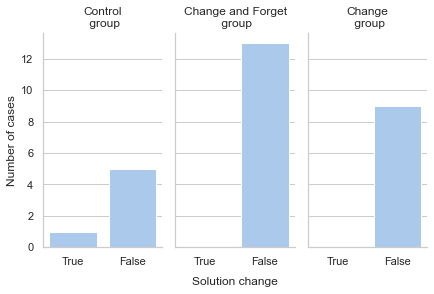

In [28]:
#plot_change_freq_by_group
table1 = solution_change_table(isinstance_table, "isinstance")
table2 = solution_change_table(enumerate_table, "enumerate")
table3 = solution_change_table(lambda_table, "lambda")
table4 = solution_change_table(sum_table, "sum")
all_change_tables = pd.concat([table1, table2, table3, table4])
all_change_tables.group = all_change_tables.group.replace({0: 'Control', 1: 'Change', 2: "Change and Forget"})

sns.set_theme(style="whitegrid", palette="pastel")
g = sns.FacetGrid(all_change_tables, col="group", height=4, aspect=.5)
g.map_dataframe(sns.countplot, "change", order=[True, False])
g.set_axis_labels("Solution change", "Number of cases")
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('Solution change', labelpad=10)
g.axes[0,2].set_xlabel('')
g.set_titles(col_template="{col_name}\n group")

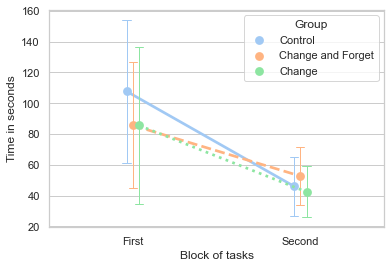

In [114]:
#plot_mean_time_for_each_block_by_group
time_table = pd.melt(all_change_tables, id_vars=['id_user', "group"], 
                     value_vars=['task_time_block0', 'task_time_block1'],
                     var_name='step', value_name='time')
time_table = time_table[(np.abs(stats.zscore(time_table["time"])) < 3)]

sns.set_theme(style="whitegrid", palette="pastel")
ax = sns.pointplot(x="step", y="time", hue="group", data=time_table, linestyles=["-", "--", ":"],
                   ci="sd", errwidth=1, capsize=.05, dodge=True)
ax.set(ylabel="Time in seconds", xlabel="Block of tasks")
ax.set_xticklabels(["First", "Second"])
plt.legend(title='Group')
plt.savefig('time.pdf', dpi=300)

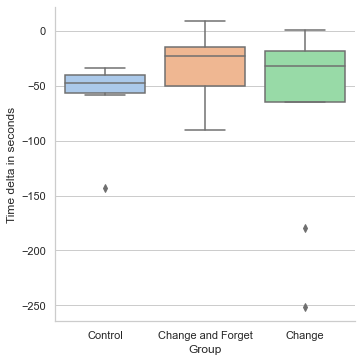

In [46]:
#plot_time_delta_by_group
delta_time_table = all_change_tables[(np.abs(stats.zscore(all_change_tables["delta_time"])) < 3)]

ax = sns.catplot(x="group", y="delta_time", data=delta_time_table, kind="box")
ax.set(ylabel="Time delta in seconds", xlabel="Group")

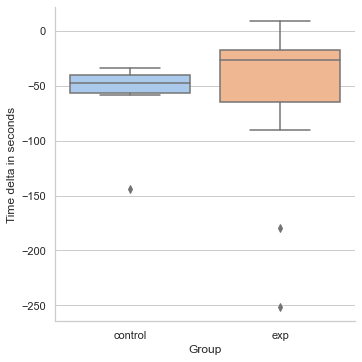

In [100]:
#plot_time_delta_by_group
ax = sns.catplot(x="group", y="delta_time", data=altered_delta_time_table, kind="box")
ax.set(ylabel="Time delta in seconds", xlabel="Group")

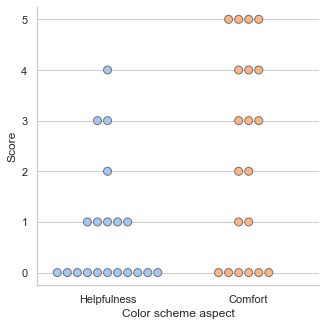

In [113]:
#plot_scores_of_comfort_and_helpfulness
how_table = isinstance_table.loc[isinstance_table.group > 0].copy(deep=True)
how_table['how_helpful'] = how_table['how_helpful'].astype(int)
how_table['how_comfortable'] = how_table['how_comfortable'].astype(int)
how_table = how_table.loc[:, ['id_user',"how_helpful", "how_comfortable"]]
how_table = pd.melt(how_table, id_vars=['id_user'], 
                     value_vars=["how_helpful", "how_comfortable"],
                     var_name='how', value_name='point')

ax = sns.catplot(x="how", y="point", kind="swarm", data=how_table, linewidth=1, height=4.5, aspect=1, s=8)
ax.set(ylabel="Score", xlabel="Color scheme aspect")
ax.set_xticklabels(["Helpfulness", "Comfort"])
plt.savefig('how.pdf', bbox_inches="tight", dpi=300)